<br />
<br />
<div align="center" style="font-size: 40pt; line-height: 54pt">

<p style="text-align: center;">Fantastic coordinates and how to transform them</p>

</div>

<br />
<br />
<br />
<div align="center" style="font-size: 20pt">

<p style="text-align: center">LST Analysis Bootcamp - LNL, Legnaro, Padova - 26.11.2018</p>

<p style="text-align: center">Thomas Gasparetto (@thomasgas)</p>

<br />
<br />

<p style="text-align: left">INFN, UNITS, UGA, LAPP</p>

<img height="300px" src="https://raw.githubusercontent.com/thomasgas/stuff/master/loghi.png" alt=""/>

</div>

## Intro

- Short presentation on the different coordinates frames that we have in ctapipe at the moment.
- More a **user point-of-view** presentation rather then a developer one.
- Changes foreseen in ctapipe before the version 1.0, but these reference frames should be **ALMOST** ok. 
- Development of frames and transformation might change (faster computation, improved , etc..)

**CREED_VTK** (CTA Rendering Event-by-Event Display with VTK)

I developed a library for the 3D rendering of the telescopes. Follow the instructions on https://github.com/thomasgas/CREED_VTK to install it inside your ctapipe environment and to use this notebook.

# inside the ctapipe environment
- git clone https://github.com/thomasgas/CREED_VTK.git
- cd CREED_VTK
- python setup.py install

**Still under development...feel free to add comments (issues) and suggestions for funtionalities!**

## Some imports...

In [1]:
import astropy.units as u
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator
from ctapipe.utils import get_dataset, get_dataset_path

from ctapipe.visualization import ArrayDisplay
from astropy.coordinates import SkyCoord

In [2]:
from ctapipe.coordinates import HorizonFrame, GroundFrame, TiltedGroundFrame
from ctapipe.coordinates import NominalFrame, CameraFrame, TelescopeFrame

In [3]:

# make plots and fonts larger
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

## Open some data. Default is the test dataset in ctapipe

In [4]:
try:
    DATA_PATH = "/home/thomas/Programs/astro/CTAPIPE_DAN/"
    filename = 'gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz'
    #filename = DATA_PATH + filename
    source = event_source(filename)
    # select layout
    layout = np.loadtxt("utils_coords/CTA.prod3Sb.3HB9-NG.lis", usecols=0, dtype=int)
    layout = set(layout)
    source.allowed_tels = layout
    source.max_events = 10
    events = [copy.deepcopy(event) for event in source]
    event = events[0]
except:
    filename = get_dataset_path("gamma_test.simtel.gz")
    source = event_source(filename)
    source.max_events = 10
    events = [copy.deepcopy(event) for event in source]
    event = events[0]
    layout = set(event.inst.subarray.tel_ids)    

In [5]:
# Calibration and find "great event"
cal = CameraCalibrator(None, None, r1_product='HESSIOR1Calibrator', extractor_product='NeighbourPeakIntegrator')
for event in events:
    cal.calibrate(event)
    
# Find "big" event
events_amplitude = []
for event in events:
    event_amplitude = 0
    for tel_id in event.r0.tels_with_data:
        if event.dl1.tel[tel_id].image is not None:
            event_amplitude += event.dl1.tel[tel_id].image[0].sum()
    events_amplitude.append(event_amplitude)
events_amplitude = np.array(events_amplitude)

mm = events_amplitude.argmax()
event = events[mm]

In [6]:
event.r0.tels_with_data

{11, 21, 24, 26, 61, 63, 118, 119}

In [7]:
tel_id = 11
event.inst.subarray.tel[tel_id]

TelescopeDescription(optics=MST, camera=NectarCam)

## HorizonFrame
Spherical system to describe the position of an object in terms of altitude and azimuth.

Pointing direction or source position in the sky is described as an HorizonFrame.

In [8]:
array_pointing = SkyCoord(
    alt=event.mcheader.run_array_direction[1],
    az=event.mcheader.run_array_direction[0], 
    frame=HorizonFrame(),
)

print(array_pointing)

<SkyCoord (HorizonFrame: pointing_direction=None, array_direction=None): (az, alt) in deg
    (0., 69.99999967)>


## CameraFrame
Camera coordinate frame. Simple physical cartesian frame describing the 2D dimensional position of objects in the focal plane of the telescope.

**Typical usage**: Position of pixels in the focal plane.

In [9]:
geom = event.inst.subarray.tel[tel_id].camera
pix_x, pix_y = geom.pix_x, geom.pix_y
fl = event.inst.subarray.tel[tel_id].optics.equivalent_focal_length   

In [10]:
telescope_pointing = SkyCoord(
    alt=event.mc.tel[tel_id].altitude_raw * u.rad, 
    az=event.mc.tel[tel_id].altitude_raw * u.rad, 
    frame=HorizonFrame()
)

camera_frame = CameraFrame(
    focal_length=fl,
    rotation=0 * u.deg,
    pointing_direction=telescope_pointing
)

cam_coords = SkyCoord(x=pix_x, y=pix_y, frame=camera_frame)

print(cam_coords)

<SkyCoord (CameraFrame: focal_length=16.0 m, rotation=0.0 deg, pointing_direction=<SkyCoord (HorizonFrame: pointing_direction=None, array_direction=None): (az, alt) in deg
    (69.99999967, 69.99999967)>, array_direction=None): (x, y) in m
    [( 0.        ,  0.        ), (-0.00944877,  0.04909909),
     (-0.0472442 ,  0.01636691), ..., (-0.6519913 , -0.96560888),
     (-0.6141959 , -0.93287672), (-0.62364467, -0.88377762)]>


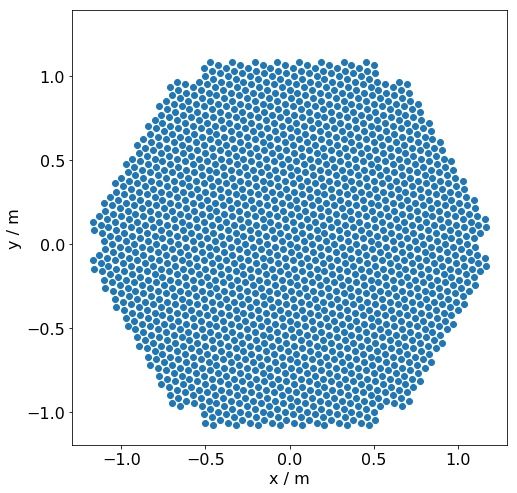

In [11]:
plt.scatter(cam_coords.x, cam_coords.y)
plt.xlabel('x / {}'.format(cam_coords.x.unit))
plt.ylabel('y / {}'.format(cam_coords.y.unit))
plt.axis('square');

## TelescopeFrame
Telescope coordinate frame. Cartesian system to describe the angular offset of a given position in reference to pointing direction of a given telescope. Pointing corrections should applied to the transformation between this frame and the camera frame.

Not really used now...

In [12]:
telescope_coords = cam_coords.transform_to(TelescopeFrame())
print(telescope_coords)

<SkyCoord (TelescopeFrame: pointing_direction=<SkyCoord (HorizonFrame: pointing_direction=None, array_direction=None): (az, alt) in deg
    (69.99999967, 69.99999967)>): (x, y) in rad
    [( 0.        ,  0.        ), (-0.00059055,  0.00306869),
     (-0.00295276,  0.00102293), ..., (-0.04074946, -0.06035055),
     (-0.03838724, -0.0583048 ), (-0.03897779, -0.0552361 )]>


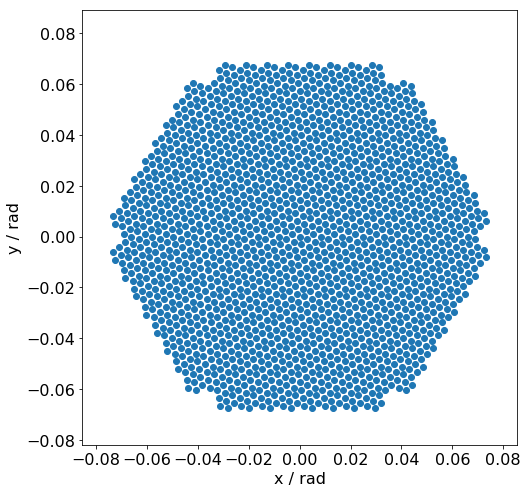

In [13]:
plt.scatter(telescope_coords.x, telescope_coords.y)
plt.xlabel('x / {}'.format(telescope_coords.x.unit))
plt.ylabel('y / {}'.format(telescope_coords.y.unit))
plt.axis('square');

## NominalFrame
Nominal coordinate frame. Cartesian system to describe the angular offset of a given position in reference to the pointing direction of a nominal array pointing. This is identical, for most of the cases, to the TelescopeFrame, a part for **divergent pointing**.

- 2D reconstruction (HillasIntersector) is performed in this frame 
- 3D reconstruction (HillasReconstructor) doesn't need this frame

NOTE: here I'm explicitely transforming:

**Camera --> Telescope --> nominal --> HorizonFrame**

**NOTE: for plotting with *%matplotlib qt*, if the plot doesn't appear or if it closes by itself, just re-run the cell. Use Ctrl + Enter**

Let's play a bit with 3 divergent LSTs

In [14]:
array_pointing = SkyCoord(alt=45 * u.deg, az=0 * u.deg, frame=HorizonFrame())

tel_pointing_1 = SkyCoord(alt=45 * u.deg, az=-5 * u.deg, frame=HorizonFrame())
tel_pointing_2 = SkyCoord(alt=45 * u.deg, az=5 * u.deg, frame=HorizonFrame())
tel_pointing_3 = SkyCoord(alt=50 * u.deg, az=0 * u.deg, frame=HorizonFrame())

tel_frame_1 = TelescopeFrame(pointing_direction=tel_pointing_1)
tel_frame_2 = TelescopeFrame(pointing_direction=tel_pointing_2)
tel_frame_3 = TelescopeFrame(pointing_direction=tel_pointing_3)

nom_frame = NominalFrame(array_direction=array_pointing)

nom_1_coords = cam_coords.transform_to(tel_frame_1).transform_to(nom_frame)
nom_2_coords = cam_coords.transform_to(tel_frame_2).transform_to(nom_frame)
nom_3_coords = cam_coords.transform_to(tel_frame_3).transform_to(nom_frame)

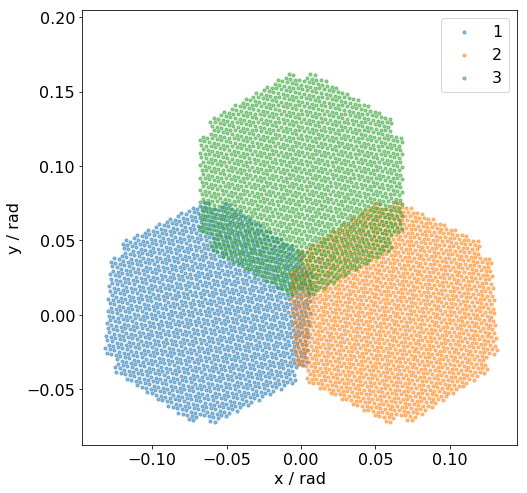

In [15]:
for i, coord in enumerate([nom_1_coords, nom_2_coords, nom_3_coords], start=1):
    plt.scatter(y=coord.x, x=coord.y, s=10, label=str(i), alpha=0.5)

plt.xlabel('x / {}'.format(coord.x.unit))
plt.ylabel('y / {}'.format(coord.y.unit))
plt.axis('square')
plt.legend()
plt.show()

In [16]:
array_pointing = SkyCoord(alt=45 * u.deg, az=0 * u.deg, frame=HorizonFrame())

tel_pointing_1 = SkyCoord(alt=45 * u.deg, az=-5 * u.deg, frame=HorizonFrame())
tel_pointing_2 = SkyCoord(alt=45 * u.deg, az=5 * u.deg, frame=HorizonFrame())
tel_pointing_3 = SkyCoord(alt=50 * u.deg, az=0 * u.deg, frame=HorizonFrame())

tel_frame_1 = TelescopeFrame(pointing_direction=tel_pointing_1)
tel_frame_2 = TelescopeFrame(pointing_direction=tel_pointing_2)
tel_frame_3 = TelescopeFrame(pointing_direction=tel_pointing_3)

nom_frame = NominalFrame(array_direction=array_pointing)

horizontal_1 = cam_coords.transform_to(tel_frame_1).transform_to(nom_frame).transform_to(HorizonFrame())
horizontal_2 = cam_coords.transform_to(tel_frame_2).transform_to(nom_frame).transform_to(HorizonFrame())
horizontal_3 = cam_coords.transform_to(tel_frame_3).transform_to(nom_frame).transform_to(HorizonFrame())

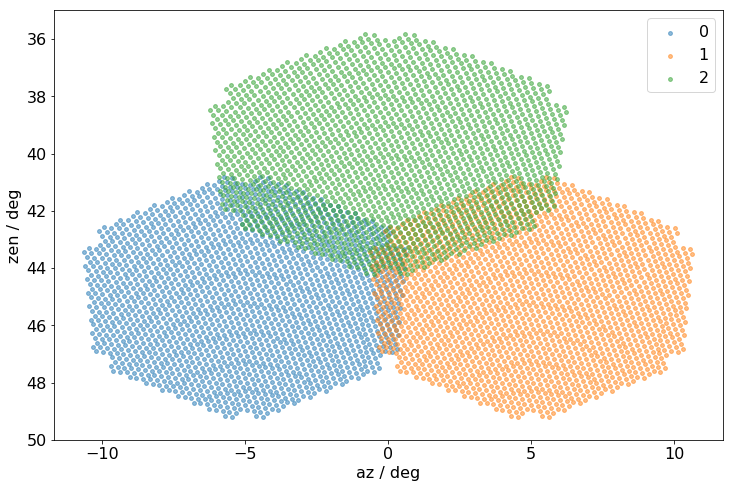

In [17]:
fig, ax = plt.subplots()

for i, coord in enumerate([horizontal_1, horizontal_2, horizontal_3]):
    ax.scatter(
        coord.az.wrap_at(180 * u.deg).deg,
        90 - coord.alt.deg,
        label=str(i),
        s=15,
        alpha=0.5
    )
    
ax.set_xlabel('az / deg')
ax.set_ylabel('zen / deg')
ax.set_ylim(50, 35)
ax.legend()
ax.set_aspect(1)

## GroundFrame
Ground coordinate frame. This is a simple cartesian frame describing the 3D position of objects compared to the array ground level in relation to the conter of the array. 

**Typical usage**: positions of telescopes on the ground (x, y, z)

/home/maxnoe/Uni/cta/ctapipe/ctapipe/instrument/subarray.py:118: UserWarning: SubarrayDescription.pos_x is deprecated. Use tel_coords.x
  warnings.warn("SubarrayDescription.pos_x is deprecated. Use "
/home/maxnoe/Uni/cta/ctapipe/ctapipe/instrument/subarray.py:125: UserWarning: SubarrayDescription.pos_y is deprecated. Use tel_coords.y
  warnings.warn("SubarrayDescription.pos_y is deprecated. Use "


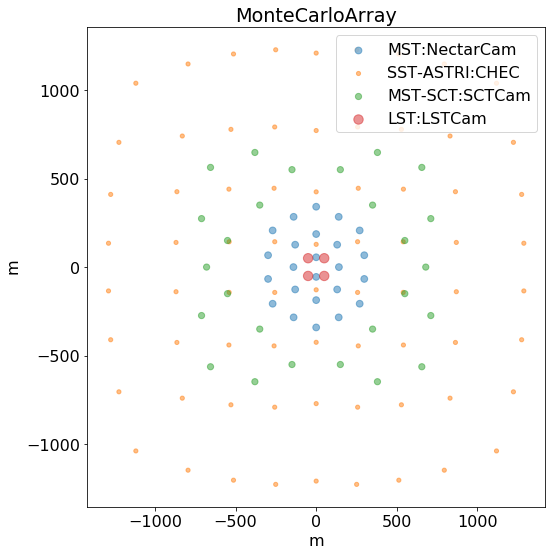

In [18]:
event.inst.subarray.peek()

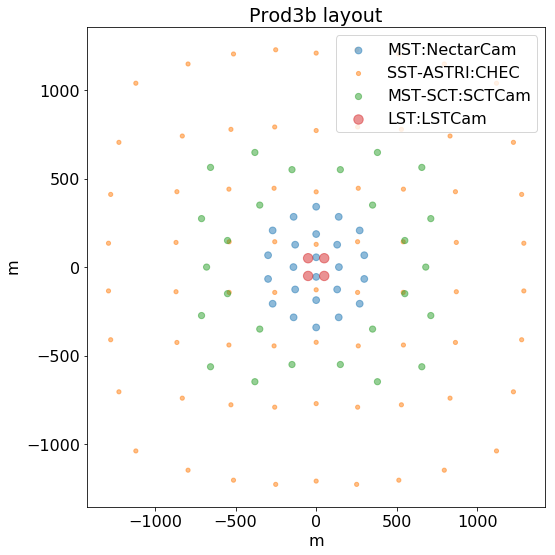

In [19]:
event.inst.subarray.select_subarray("Prod3b layout", layout).peek()

### Telescopes position in 3D

In [20]:
from CREED_VTK import CREED_VTK 

In [21]:
try:
    render = CREED_VTK(event, telescopes_ids=list(layout))
except:
    render = CREED_VTK(event, telescopes_ids= event.inst.subarray.tel_ids.tolist())
render.add_gnd_tels()
render.add_gnd_frame(size=2000)
render.tel_labels()

render.camera_view(elev=20)
render.show(width= 1000, height=800)

## TiltedGroundFrame
Tilted ground coordinate frame. Cartesian system describing the 2D dimensional projected positions of objects in a tilted plane described by the pointing direction (HorizonFrame). 

**Tipical usage**: shower core position reconstruction.

In [22]:
array_pointing = SkyCoord(alt=event.mcheader.run_array_direction[1],
                          az=event.mcheader.run_array_direction[0], 
                          frame=HorizonFrame())

In [23]:
try:
    render = CREED_VTK(event, telescopes_ids=list(layout))
except:
    render = CREED_VTK(event, telescopes_ids= event.inst.subarray.tel_ids.tolist())
render.add_gnd_tels()
render.add_gnd_frame(size=2000)
render.tel_labels() 

render.add_tilted_tels()
render.add_tilted_frame(size=2000)

render.camera_view(elev=20)
render.show(width= 1000, height=800)